In [1]:
import sys
import os
import glob
import random
import copy
import math
from IPython.display import display, Markdown
from mpmath.libmp.libmpf import h_mask_small
from numpy.lib.function_base import hamming

from hydradx.model.hollar import StabilityModule

sys.path.append('../..')

from matplotlib import pyplot as plt

from model.amm.stableswap_amm import StableSwapPoolState, simulate_swap
from model.amm.agents import Agent
from model.hollar import StabilityModule



In [2]:
hsm_liquidity = {'USDT': 1000000}
hol_pct = 0.97
initial_tvl = 1000000
buyback_speed = 1/10000
sell_price = 1.01
max_buy_price = 0.999
buy_fee = 0.0001
init_hollar = initial_tvl * hol_pct
tokens = {'HOLLAR': init_hollar, 'USDT': initial_tvl * (1 - hol_pct)}
pool = StableSwapPoolState(tokens=tokens, amplification=100, trade_fee=0.0001)
hsm = StabilityModule(
    liquidity = hsm_liquidity,
    buyback_speed = buyback_speed,
    pools = [pool],
    sell_price = sell_price,
    max_buy_price = max_buy_price,
    buy_fee = buy_fee
)
agent = Agent(holdings={'HOLLAR': 0, 'USDT': 1000})
print("initial pool price:")
print(pool.buy_spot(tkn_buy='HOLLAR', tkn_sell='USDT'))
buy_amts = []
buy_prices = []
buy_spots = []
hsm_liquidity_history = []
for i in range(30000):
    buy_amt, buy_price = hsm.get_buy_params(tkn='USDT')
    hsm.arb(agent, tkn='USDT')
    buy_amts.append(buy_amt)
    buy_prices.append(buy_price)
    buy_spots.append(pool.buy_spot(tkn_buy='HOLLAR', tkn_sell='USDT'))
    hsm_liquidity_history.append(hsm.liquidity['USDT'])

hollar_burned = init_hollar - pool.liquidity['HOLLAR']

print(pool.liquidity)
print('total Hollar bought off market: ' + str(hollar_burned))
print('total USDT paid by stability module: ' + str(1000000 - hsm.liquidity['USDT']))
print('arbitrager profits: ' + str(agent.holdings['USDT']))
print('average price paid by stability module: ' + str((1000000 - hsm.liquidity['USDT']) / hollar_burned))
print("final pool price: " + str(pool.buy_spot(tkn_buy='HOLLAR', tkn_sell='USDT')))



initial pool price:
0.4539462870165215
{'HOLLAR': 512157.7907609079, 'USDT': 454002.3901687622}
total Hollar bought off market: 457842.2092390921
total USDT paid by stability module: 424044.79464823566
arbitrager profits: 1042.4044794647898
average price paid by stability module: 0.926181086171531
final pool price: 0.9989001501090348


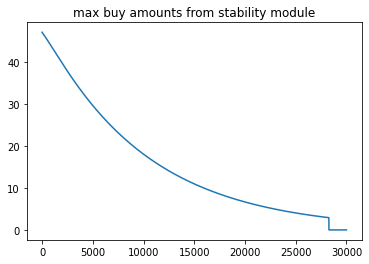

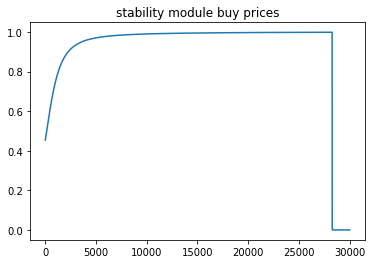

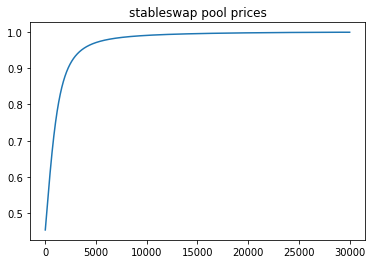

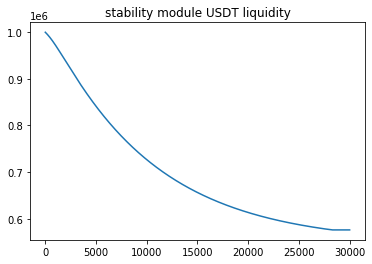

In [3]:
plt.plot(buy_amts)
plt.title("max buy amounts from stability module")
plt.show()
plt.plot(buy_prices)
plt.title("stability module buy prices")
plt.show()
plt.plot(buy_spots)
plt.title("stableswap pool prices")
plt.show()
plt.plot(hsm_liquidity_history)
plt.title("stability module USDT liquidity")
plt.show()

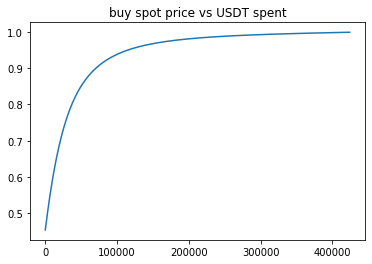

In [4]:
usdt_spent = [1000000 - hsm_liquidity for hsm_liquidity in hsm_liquidity_history]
plt.plot(usdt_spent, buy_spots)
plt.title("buy spot price vs USDT spent")
plt.show()